In [20]:
import cv2
import numpy as np
import pandas as pd

In [21]:
def readImg(url):
    return cv2.imread(url, 0)

trainNames = ['data/' + '{0:03d}'.format(ppl) + '/1/' + '{0:03d}'.format(ppl) + '_1_'  
              for ppl in list(range(1, 109))]
trainNames = [[x + str(trial) + '.bmp' for trial in list(range(1, 4))] for x in trainNames]

train_image = pd.DataFrame(columns=['Image'])
train_image['Image'] = list(map(readImg, np.ravel(trainNames)))
train_image.index = np.ravel(trainNames)

testNames = ['data/' + '{0:03d}'.format(ppl) + '/2/' + '{0:03d}'.format(ppl) + '_2_'  
             for ppl in list(range(1, 109))]
testNames = [[x + str(trial) + '.bmp' for trial in list(range(1, 5))] for x in testNames]

test_image = pd.DataFrame(columns=['Image'])
test_image['Image'] = list(map(readImg, np.ravel(testNames)))
test_image.index = np.ravel(testNames)

In [22]:
#%% Parameters

k1 = 5 # kernel size for first bilateral filter (pupil identification)
k2 = 9 # kernel size for first bilateral filter (iris identification)

window = 60 # size of window for subsetting image (120 * 120)

thresh1 = 80 # Binary image thresholding value for pupil
thresh2 = 150 # Binary image thresholding value for iris (155, 170)
scope1 = 1.6 # Lower boundary for iris radius size in respect to pupil radius
scope2 = 3.6 # Upper boundary for iris radius size in respect to iris radius
hough_list = [5,5] #hough variables for hough circles


## Helpers


In [23]:
def projection(img):
    (h, w) = img.shape
    h = h-window
    w = w-window
    sumCols = []
    sumRows = []
    lim = int(window/2)
    for i in range(h):
        row = img[i+lim:i+lim+1, 0:w] 
        sumRows.append(np.sum(row))
    for j in range(w):
        col = img[0:h, j+lim:j+lim+1]
        sumCols.append(np.sum(col))
    return sumRows, sumCols
    
#%% Subsetting: getting a subset of image based on center point (posX, posY) and window size.
    
def subsetting(img, posX, posY, window):
    if ((posY<window) and (posX<window)):
        img = img[0:posY+window, 0:posX+window]
    elif ((posY<window) and (posX>=window)):
        img = img[0:posY+window, posX-window:posX+window]
    elif ((posY>=window) and (posX<window)):
        img = img[posY-window:posY+window, 0:posX+window]
    else:
        img = img[posY-window:posY+window, posX-window:posX+window]
    cv2.imwrite("la.png",img)
    return img

#%% Thresholding: binary image thresholding & getting center of pupil from moments.
    
def thresholding(orig, posX, posY, window, otsu=True):
    img = orig.copy()
    img = subsetting(img, posX, posY, window)
    
    if otsu:
        ret,th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret,th = cv2.threshold(img, thresh2, 255, cv2.THRESH_BINARY_INV)
    
    M = cv2.moments(th)
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    posY = int(posY+cY-window)
    posX = int(posX+cX-window)
    
    return posX, posY

#%% boundary: see if iris center is inside pupil.
# circle_detect: use houghcircles to find the iris
# circle_detectX: use houghcircles & boundary to find the pupil.
    
def boundary(x1, x2, y1, y2, r):
    if np.sqrt(np.power((y1-x1), 2) + np.power((y2-x2), 2)) < r:
        return True
    else:
        return False
    
def circle_detect(edges, dp = 20, minR = 20, maxR = 0, bound=False, posX=0, posY=0, radius=0):
    if bound == False:
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, dp, 
                           param1=hough_list[0], param2=hough_list[1], 
                           minRadius = minR, maxRadius=maxR)
        if len(circles) >= 1:
            return circles[0][0] 
        else:
            return [0, 0, 0]

    else:
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, dp, 
                       param1=hough_list[0], param2=hough_list[1], 
                       minRadius = minR, maxRadius=maxR)
        circles = [x for x in circles[0] if boundary(x[0], x[1], posX, posY, (radius/2))]
        if len(circles) >= 1:
            return circles[0] 
        else:
            return [posX, posY, radius]
        
def circle_detectX(edges, dp, posX, posY, radius, minR = 20, maxR = 0):
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, dp, 
                       param1=hough_list[0], param2=hough_list[1], 
                       minRadius = minR, maxRadius=maxR)
    circles = [x for x in circles[0] if boundary(x[0], x[1], posX, posY, (radius/2))]
    if len(circles) >= 1:
        return circles[0]  


## Localization

In [24]:
def IrisLoc2(orig, name): 
    (h, w) = orig.shape 
    img = orig.copy()
    
    kernel = np.ones((k1,k1),np.float32)/np.power(k1, 2)
    img = cv2.filter2D(img,-1,kernel)
    
    ret,th = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    
    edges = cv2.Canny(th, 0, ret)
    
    circle = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 50, 
                               param1=5, param2=5, 
                               minRadius=30, maxRadius=90)[0][0]
    img_copy = orig.copy()
    
    try:
        p_posY = int(circle[1])
        p_posX = int(circle[0])
        p_radius = int(circle[2])
    except TypeError:
        print("No pupil")
        p_posY = 0
        p_posX = 0
        p_radius = 0
    
    cv2.circle(img_copy,(p_posX,p_posY),p_radius,(255,255,255),2)
    cv2.circle(img_copy,(p_posX,p_posY),2,(255,255,255),3)   
    
    outer = np.mean([img[x] for x in list(zip(*np.where(th == 255)))])
    pupil = list(zip(*np.where(th == 0)))
    pupil = [(x[0], x[1]) for x in pupil]
        
    img = orig.copy()
    for x in pupil:
        img[x] = outer
    
    kernel = np.ones((k2,k2),np.float32)/np.power(k2, 2)
    img = cv2.filter2D(img,-1,kernel)
    
    ret2,th2 = cv2.threshold(img, thresh2, 255, cv2.THRESH_BINARY)
    
    edges2 = cv2.Canny(th2, 0, ret2)
        
    circle2 = circle_detect(edges2, dp = 10, minR = 90, maxR = 120, bound=True, 
                            posX=p_posX, posY=p_posY, radius=p_radius*0.75) 
    s_posY = circle2[1]
    s_posX = circle2[0]
    s_radius = int(circle2[2])  
      
#    circle2 = circle_detectX(edges2, 10, p_posX, p_posY, p_radius*0.75, 90, 120)
#        
#    try:
#        s_posY = circle2[1]
#        s_posX = circle2[0]
#        s_radius = int(circle2[2])
#    except TypeError:
#        print("No schelra")
#        s_posY = p_posY
#        s_posX = p_posX
#        s_radius = p_radius*2
     
    cv2.circle(img_copy,(int(p_posX),int(p_posY)),p_radius,(255,255,255),2)
    cv2.circle(img_copy,(int(p_posX),int(p_posY)),2,(255,255,255),3)    
    cv2.circle(img_copy,(int(s_posX),int(s_posY)),s_radius,(255,255,255),2)
    cv2.circle(img_copy,(int(s_posX),int(s_posY)),2,(255,255,255),3)    

    i_lowY = int(s_posY - s_radius) if int(s_posY - s_radius) >= 0 else 0
    i_highY = int(s_posY + s_radius + 1) if int(s_posY + s_radius + 1) <= h else s_radius
    
    i_lowX = int(s_posX - s_radius) if int(s_posX - s_radius) >= 0 else 0
    i_highX = int(s_posX + s_radius + 1) if int(s_posX + s_radius + 1) <= w else s_radius
    
    iris = img[i_lowY:i_highY, i_lowX:i_highX]
    
    x = np.arange(0, iris.shape[0])
    y = np.arange(0, iris.shape[1])
    
    mask = (x[np.newaxis,:]-s_radius)**2 + (y[:,np.newaxis]-s_radius)**2 > s_radius**2
    iris[mask.T] = 255
    
    topvar = int(p_posY - i_lowY - p_radius)
    topeyelid = iris[0:topvar, :]
    
    ret,th = cv2.threshold(topeyelid, 115, 255, cv2.THRESH_BINARY)
    try:
        th = cv2.Canny(th, 0, ret)
        topeyelash = th.argmax(0)
        x = np.argwhere(topeyelash > 0).reshape(1,-1)[0]
        y = topeyelash[topeyelash > 0]
    except AttributeError:
        y = []

    img_copy2 = orig.copy()
    img_copy2 = img_copy2.astype(np.float32)
    
    if len(y) > 50:
        P = np.array([np.square(x), x, np.ones(len(x))])
        Q = np.matmul(np.linalg.inv(np.matmul(P, P.T)), np.matmul(P, y.reshape(-1,1)))
        
        x = np.arange(0, len(topeyelash), 1)
        y = (Q[0][0]*(x**2)+Q[1][0]*x+Q[2][0])
        
        for i, el in enumerate(y):
            if el > 0 and el < topeyelid.shape[0]:
                img_copy[int(el)+i_lowY, i+i_lowX] = 255
                    
        cv2.imwrite('process/l_' + str(name.split('/')[3]), img_copy)   
        
        for i, el in enumerate(y):
            if el > 0:
                el_int = int(el)
                i_lowY_int = int(i_lowY)
                i_lowX_int = int(i_lowX)
                i_int = int(i)
                img_copy2[0:int(el)+i_lowY, i+i_lowX] = np.nan
    else:
        cv2.imwrite('process/l_' + str(name.split('/')[3]), img_copy)  
    cv2.imwrite("we7shaorig.png",orig)
    cv2.imwrite("we7shacopy.png",img_copy2)    
    return [p_posX, p_posY, p_radius, s_posX, s_posY, s_radius, orig, img_copy2]


In [25]:
def localize(orig, name):  
    (h, w) = orig.shape        
     
    sumRows, sumCols = projection(orig)
    
    posX = np.argmin(sumCols) + int(window/2)
    posY = np.argmin(sumRows) + int(window/2)
    
    posX, posY = thresholding(orig, posX, posY, window)
    
    posX, posY = thresholding(orig, posX, posY, window)
    
    img = orig.copy()
    img = subsetting(img, posX, posY, window)
    kernel = np.ones((k1,k1),np.float32)/np.power(k1, 2)
    img = cv2.filter2D(img,-1,kernel)
    
    ret,th = cv2.threshold(img, thresh1, 255, cv2.THRESH_BINARY)
    
    edges = cv2.Canny(th, 0, ret)
    
    circle = circle_detect(edges, minR=20, maxR=70)
    
    img_copy = orig.copy()
    
    p_posY = int(posY+circle[1]-window)
    p_posX = int(posX+circle[0]-window)
    p_radius = int(circle[2])
    
    if np.sqrt(np.power(p_posX-(h/2), 2) + np.power(p_posY-(w/2), 2)) >= 80:
        return IrisLoc2(orig, name)
        
    outer = np.mean([img[x] for x in list(zip(*np.where(th == 255)))])
    pupil = list(zip(*np.where(th == 0)))
    pupil = [(posY + x[0] - window, posX + x[1] - window) for x in pupil]
    
    img = orig.copy()
    for x in pupil:
        img[x] = outer

    kernel = np.ones((k2,k2),np.float32)/np.power(k2, 2)
    img2 = cv2.filter2D(img,-1,kernel)
    
    ret2,th2 = cv2.threshold(img2, thresh2, 255, cv2.THRESH_BINARY)
    
    edges2 = cv2.Canny(th2, 0, ret2)
    
    if int(name.split('/')[2]) == 1:
        circle2 = circle_detect(edges2, dp = 10, minR = 90, maxR = 140, bound=True, 
                            posX=p_posX, posY=p_posY, radius=p_radius*0.75) 
    else:
        circle2 = circle_detect(edges2, dp = 10, minR = 90, maxR = 120, bound=True, 
                            posX=p_posX, posY=p_posY, radius=p_radius*0.75) 
    
    s_posY = circle2[1]
    s_posX = circle2[0]
    s_radius = int(circle2[2]) 

    cv2.circle(img_copy,(int(p_posX),int(p_posY)),p_radius,(255,255,255),2)
    cv2.circle(img_copy,(int(p_posX),int(p_posY)),2,(255,255,255),3)    
    cv2.circle(img_copy,(int(s_posX),int(s_posY)),s_radius,(255,255,255),2)
    cv2.circle(img_copy,(int(s_posX),int(s_posY)),2,(255,255,255),3)    

    img_copy2 = orig.copy()
    img_copy2 = img_copy2.astype(np.float32)
    
    i_lowY = int(s_posY - s_radius) if int(s_posY - s_radius) >= 0 else 0
    i_highY = int(s_posY + s_radius + 1) if int(s_posY + s_radius + 1) <= h else s_radius
    
    i_lowX = int(s_posX - s_radius) if int(s_posX - s_radius) >= 0 else 0
    i_highX = int(s_posX + s_radius + 1) if int(s_posX + s_radius + 1) <= w else s_radius
    
    iris = img[i_lowY:i_highY, i_lowX:i_highX]
    
    x = np.arange(0, iris.shape[0])
    y = np.arange(0, iris.shape[1])
    
    mask = (x[np.newaxis,:]-s_radius)**2 + (y[:,np.newaxis]-s_radius)**2 > s_radius**2
    iris[mask.T] = 255
    
    topvar = int(p_posY - i_lowY - p_radius)
    topeyelid = iris[0:topvar, :]
    
    ret,th = cv2.threshold(topeyelid, 115, 255, cv2.THRESH_BINARY)
    try:
        th = cv2.Canny(th, 0, ret)
        topeyelash = th.argmax(0)
        x = np.argwhere(topeyelash > 0).reshape(1,-1)[0]
        y = topeyelash[topeyelash > 0]
    except AttributeError:
        y = []

    if len(y) > 50:
        P = np.array([np.square(x), x, np.ones(len(x))])
        Q = np.matmul(np.linalg.inv(np.matmul(P, P.T)), np.matmul(P, y.reshape(-1,1)))
        
        x = np.arange(0, len(topeyelash), 1)
        y = (Q[0][0]*(x**2)+Q[1][0]*x+Q[2][0])
        
        for i, el in enumerate(y):
            if el > 0 and el < topeyelid.shape[0]:
                img_copy[int(el)+i_lowY, i+i_lowX] = 255
                    
        cv2.imwrite('process/l_' + str(name.split('/')[3]), img_copy)   
        
        for i, el in enumerate(y):
            if el > 0:
                el_int = int(el)
                i_lowY_int = int(i_lowY)
                i_lowX_int = int(i_lowX)
                i_int = int(i)
                img_copy2[0:el_int + i_lowY_int, i_int + i_lowX_int] = np.nan
    else:
        cv2.imwrite('process/l_' + str(name.split('/')[3]), img_copy)  
    cv2.imwrite("ablnormorig.png",orig)
    cv2.imwrite("ablnormcopy.png",img_copy2)        
    return [p_posX, p_posY, p_radius, s_posX, s_posY, s_radius, orig, img_copy2]

## Normalization

In [26]:
def normalize(row):
    name = row.name
    image = row['img']
    noisyimage = row['imgNoise']
    
    M = 64
    N = 512
    
    theta = np.linspace(0, 2*np.pi, N)

    diffX = row['p_posX'] - row['i_posX']
    diffY = row['p_posY'] - row['i_posY']

    a = np.ones(N) * (diffX**2 + diffY**2)
    
    if diffX < 0:
        phi = np.arctan(diffY/diffX)
        sgn = -1
    elif diffX > 0:
        phi = np.arctan(diffY/diffX)
        sgn = 1
    else:
        phi = np.pi/2
        if diffY > 0:
            sgn = 1
        else:
            sgn = -1

    b = sgn * np.cos(np.pi - phi - theta)

    r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - row['i_radius']**2))
    r = np.array([r - row['p_radius']])
    r = np.dot(np.ones([M+2,1]), r) * np.dot(np.ones([N,1]),
                        np.array([np.linspace(0,1,M+2)])).transpose()
    r = r + row['p_radius']
    r = r[1:M+1, :]

    xcosmat = np.dot(np.ones([M,1]), np.array([np.cos(theta)]))
    xsinmat = np.dot(np.ones([M,1]), np.array([np.sin(theta)]))

    x = r*xcosmat
    y = r*xsinmat

    x += row['p_posX']
    x = np.round(x).astype(int)
    x[np.where(x >= image.shape[1])] = image.shape[1] - 1
    x[np.where(x < 0)] = 0
    
    y += row['p_posY']
    y = np.round(y).astype(int)
    y[np.where(y >= image.shape[0])] = image.shape[0] - 1
    y[np.where(y < 0)] = 0
    
    newImg = image[y, x]
    noiseImg = noisyimage[y, x]
    
    coords = np.where((np.isnan(noiseImg)))
    newImg2 = newImg
    newImg2[coords] = 0.5
    avg = np.sum(newImg2) / (newImg.shape[0] * newImg.shape[1])
    newImg[coords] = avg
    
    cv2.imwrite('process/n_' + str(name.split('/')[3]), newImg)    
    
    return newImg


## Enhancement

In [27]:
def enhancement(row):
    img = row['Image']
    dim = img.shape
    
    stride = 16  
    initialize_img = np.zeros((int(dim[0]/stride), int(dim[1]/stride)))
    
    for i in range(0,dim[0]-15,stride):
        for j in range(0,dim[1]-15,stride):
            block = img[i:i+stride, j:j+stride]
            m = np.mean(block,dtype=np.float32)
            initialize_img[i//16, j//16] = m
            
    image_set = cv2.resize(initialize_img, (dim[1],dim[0]), interpolation=cv2.INTER_CUBIC)

    enhance = img - image_set
    enhance = enhance - np.amin(enhance.ravel())
    img = enhance.astype(np.uint8)      
         
    img2 = np.zeros(dim)
    for i in range(0,img.shape[0],stride*2):
        for j in range(0,img.shape[1],stride*2):
            img2[i:i+stride*2, j:j+stride*2] = cv2.equalizeHist(img[i:i+stride*2, j:j+stride*2].astype(np.uint8))
    cv2.imwrite('process/e_' + str(row.name.split('/')[3]), img2)

    return img2

## Running Pipeline


In [28]:

#%% Localization
print('Starting Iris Localization')
train_local = train_image.apply(lambda x: localize(x['Image'], str(x.name)), axis=1, result_type='expand')
train_local.columns = ['p_posX', 'p_posY', 'p_radius', 'i_posX', 'i_posY', 'i_radius', 'img', 'imgNoise']
test_local = test_image.apply(lambda x: localize(x['Image'], str(x.name)), axis=1, result_type='expand')
test_local.columns = ['p_posX', 'p_posY', 'p_radius', 'i_posX', 'i_posY', 'i_radius', 'img', 'imgNoise']

#%% Normalization:
print('Starting Iris Normalization')
train_norm = train_local.apply(lambda x: normalize(x), axis=1)
train_norm = train_norm.to_frame()
train_norm.columns = ['Image']
test_norm = test_local.apply(lambda x: normalize(x), axis=1)
test_norm = test_norm.to_frame()
test_norm.columns = ['Image']

#%% Enhancement:
print('Starting Iris Enhancement')
train_enh = train_norm.apply(enhancement, axis=1)
train_enh = train_enh.to_frame()
train_enh.columns = ['Image']
test_enh = test_norm.apply(enhancement, axis=1)
test_enh = test_enh.to_frame()
test_enh.columns = ['Image']


Starting Iris Localization
Starting Iris Normalization
Starting Iris Enhancement


## Feature extraction

In [29]:

import numpy as np
import itertools
from scipy.signal import convolve2d

#%%
region = 40
ksize = 3

sigma1 = 3
gamma1 = 2

sigma2 = 4.5
gamma2 = 3

dim = 8
                   
#%%
def def_filter(size, sigma, theta, freq, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    xmax = int((size-1)/2)
    ymax = int((size-1)/2)
    xmin = -xmax
    ymin = -ymax
    (x, y) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    M0 = np.exp(-0.5 * ((x_theta/sigma_x)**2  + (y_theta/sigma_y)**2)) 
    M1 = np.cos(2 * np.pi * freq * np.sqrt((x_theta)**2 + (y_theta)**2))
    gb = (1/(2 * np.pi * sigma_x * sigma_y)) * M0 * M1
    return gb

#%%
def build_filters(ksize, sigma, freq, gamma):
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = def_filter(ksize, sigma, theta, gamma/sigma, gamma)
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = convolve2d(img, kern, 'same')
        np.maximum(accum, fimg, accum)
    return accum

#%%   
def feature_vect(res1, res2, dim): 
    sizeX, sizeY = res1.shape    
    x = np.linspace(0, (sizeX // dim) - 1, num=sizeX // dim, dtype=int)
    y = np.linspace(0, (sizeY // dim) - 1, num=sizeY // dim, dtype=int)
    xy = np.array(list(itertools.product(x, y)))
    xy = xy.astype(int)
    
    patches1 = [res1[a[0]*dim:a[0]*dim+dim, a[1]*dim:a[1]*dim+dim] for a in xy]
    patches2 = [res2[a[0]*dim:a[0]*dim+dim, a[1]*dim:a[1]*dim+dim] for a in xy]
    
    mean1 = [np.mean(x) for x in patches1]
    sigma1 = [np.mean(np.abs(a-b)) for a, b in zip(patches1, mean1)]
    
    V = []
    for i, v in enumerate(mean1):
        V.append(v)
        V.append(sigma1[i])
        
    mean2 = [np.mean(x) for x in patches2]
    sigma2 = [np.mean(np.abs(a-b)) for a, b in zip(patches2, mean2)]
    
    for i, v in enumerate(mean2):
        V.append(v)
        V.append(sigma2[i])
        
    return V

#%%
def extract(row):
    image = row['Image']
    image = image[:region,]
    
    filters1 = build_filters(ksize, sigma1, gamma1/sigma1, gamma1)
    filters2 = build_filters(ksize, sigma2, gamma2/sigma2, gamma2)
    
    res1 = process(image, filters1)
    res2 = process(image, filters2)
    
    V = feature_vect(res1, res2, dim)
    return V

## Matching

In [30]:

import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

#%%
def match(x_train, y_train, x_test, y_test, reduction, n_comp=120):
    if reduction:
        x_train = StandardScaler().fit_transform(x_train)
        x_test = StandardScaler().fit_transform(x_test)
        pca = PCA(n_components=n_comp).fit(x_train)
        x_train_red = pca.transform(x_train)
        x_test_red = pca.transform(x_test)
        clf = LDA().fit(x_train_red, y_train)
    else:
        x_train_red = x_train
        x_test_red = x_test

    [n1,m1] = x_train_red.shape
    [n2,m2] = x_test_red.shape
    [n, m] = x_train.shape
    
    l = len(np.unique(y_train))
    fi=np.zeros((l,m1))
    
    for i in range(l):
        group = x_train_red[list(np.where(y_train==i+1)),:][0]
        fi[i,:]=(np.mean(group, axis=0))
    
    if reduction:
        x_test_red = clf.transform(x_test_red)
        fi = clf.transform(fi)
        
    d1 = np.zeros((n2,l))
    d2 = np.zeros((n2,l))
    d3 = np.zeros((n2,l))
    
    values_y = np.zeros((n2, 3))
    pred_y = np.zeros((n2, 3))
    for i in range(n2):
        for j in range(l):
            d1[i,j] = sum(abs((x_test_red[i,:]-fi[j,:])))
            d2[i,j] = sum((x_test_red[i,:]-fi[j,:])**2);              
            d3[i,j] = 1-(np.dot(x_test_red[i,:].T, fi[j,:]))/(np.linalg.norm(x_test_red[i,:])*np.linalg.norm(fi[j,:]))
         
        values_y[i, 0] = np.min(d1[i,:])
        values_y[i, 1] = np.min(d2[i,:])
        values_y[i, 2] = np.min(d3[i,:])
        pred_y[i, 0] = np.argmin(d1[i,:])+1
        pred_y[i, 1] = np.argmin(d2[i,:])+1
        pred_y[i, 2] = np.argmin(d3[i,:])+1
        
    return values_y, pred_y

## Evaluation

In [31]:
import numpy as np
from IrisMatching import match
import matplotlib.pyplot as plt

#%%
def evaluation(l1, l2):
    return (np.sum(l1 == l2)*1.0/len(l2))*100

#%%
def create_table(y_pred_d0, y_pred_d, y_test):
    return_text = ""
    return_text += ("Original, L1 measure: " + str(evaluation(y_pred_d0[:,0], y_test).round(1)) + "%,     ")
    return_text += ("Reduced, L1 measure: " + str(evaluation(y_pred_d[:,0], y_test).round(1)) + "% \n")
    return_text += ("Original, L2 measure: " + str(evaluation(y_pred_d0[:,1], y_test).round(1)) + "%,     ")
    return_text += ("Reduced, L2 measure: " + str(evaluation(y_pred_d[:,1], y_test).round(1)) + "% \n")
    return_text += ("Original, Cosine measure: " + str(evaluation(y_pred_d0[:,2], y_test).round(1)) + "%, ")
    return_text += ("Reduced, Cosine measure: " + str(evaluation(y_pred_d[:,2], y_test).round(1)) + "% \n")
    return return_text

#%%
def dimension_plot(x_train, x_test, y_train, y_test):
    dim_fv = np.arange(10, 140, 10)
    rates = np.zeros(len(dim_fv))
    for i, v in enumerate(dim_fv):
        _, d3 = match(x_train, y_train, x_test, y_test, True, n_comp=v)
        rates[i] = (evaluation(d3[:,2], y_test))
        
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_xlabel("Dimensionality of the feature vector")
    ax.set_ylabel("Correct regonition rate")
    ax.plot(np.arange(10, 140, 10), rates, label="recognition rate", marker='o')
    ax.legend(loc="best", fontsize="large")
    plt.show()

#%%
def falsematch(val, pred, thresh):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i, v in enumerate(val):
        if v < thresh:
            if pred[i] == (i//4)+1:
                TP += 1
            else:
                FP += 1
        else:
            if pred[i] == (i//4)+1:
                FN += 1
            else:
                TN += 1
    
    return (FP*1.0/(TP+FP) if TP+FP != 0 else 0, 
            FN*1.0/(TN+FN) if TN+FN != 0 else 0, 
            TP*1.0/(TP+FN) if TP+FN != 0 else 0, 
            FP*1.0/(FP+TN) if TP+FN != 0 else 0)
    
#%%
def create_table2(val_d, y_pred_d):
    fm_446 = falsematch(val_d[:,2], y_pred_d[:,2], 0.446)
    fm_472 = falsematch(val_d[:,2], y_pred_d[:,2], 0.472)
    fm_502 = falsematch(val_d[:,2], y_pred_d[:,2], 0.502)

    return_text = ""
    return_text += ("False Match (Threshold: 0.446): " + str(round(fm_446[0], 3)) + ", ")
    return_text += ("False Non Match (Threshold: 0.446): " + str(round(fm_446[1], 3)) + "\n")
    return_text += ("False Match (Threshold: 0.472): " + str(round(fm_472[0], 3)) + ", ")
    return_text += ("False Non Match (Threshold: 0.472): " + str(round(fm_472[1], 3)) + "\n")
    return_text += ("False Match (Threshold: 0.502): " + str(round(fm_502[0], 3)) + ", ")
    return_text += ("False Non Match (Threshold: 0.502): " + str(round(fm_502[1], 3)) + "\n")
    return return_text
    
#%%
def fp_plot(val_d, y_pred_d):
    thresh = np.arange(0.1, 0.8, 0.002)
    false_match = []
    false_nonmatch = []
    true_positive = []
    false_positive = []
    for i in thresh:
        res = falsematch(val_d[:,2], y_pred_d[:,2], i)
        false_match.append(res[0])
        false_nonmatch.append(res[1])
        true_positive.append(res[2])
        false_positive.append(res[3])

    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_xlabel("False Match")
    ax.set_ylabel("False Non-Match")
    ax.plot(false_match, false_nonmatch)
    
    plt.show()


Starting Feature Extraction
Starting Iris Matching


g:\4th year biomedical\Biometrics\trash\.s\OpenCV_IrisRecognition\IrisMatching.py:51: RuntimeWarning: invalid value encountered in scalar divide
  d3[i,j] = 1-(np.dot(x_test_red[i,:].T, fi[j,:]))/(np.linalg.norm(x_test_red[i,:])*np.linalg.norm(fi[j,:]))


Evaluation Results
Original, L1 measure: 81.5%,     Reduced, L1 measure: 80.3% 
Original, L2 measure: 76.4%,     Reduced, L2 measure: 76.6% 
Original, Cosine measure: 75.5%, Reduced, Cosine measure: 84.7% 



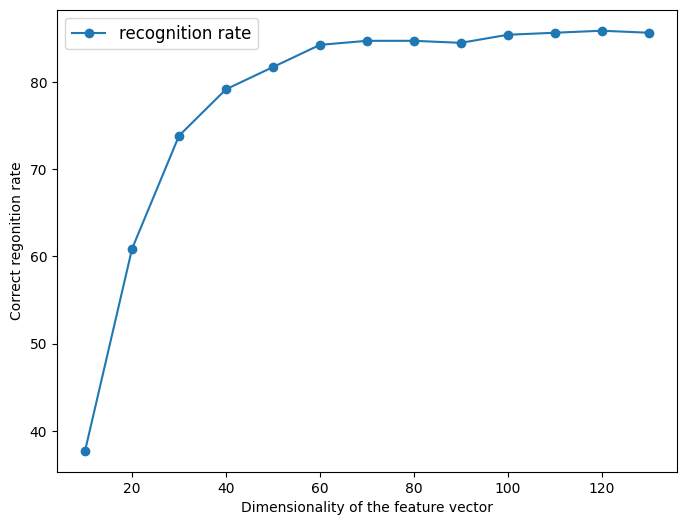

False Match (Threshold: 0.446): 0.007, False Non Match (Threshold: 0.446): 0.504
False Match (Threshold: 0.472): 0.01, False Non Match (Threshold: 0.472): 0.471
False Match (Threshold: 0.502): 0.024, False Non Match (Threshold: 0.502): 0.402



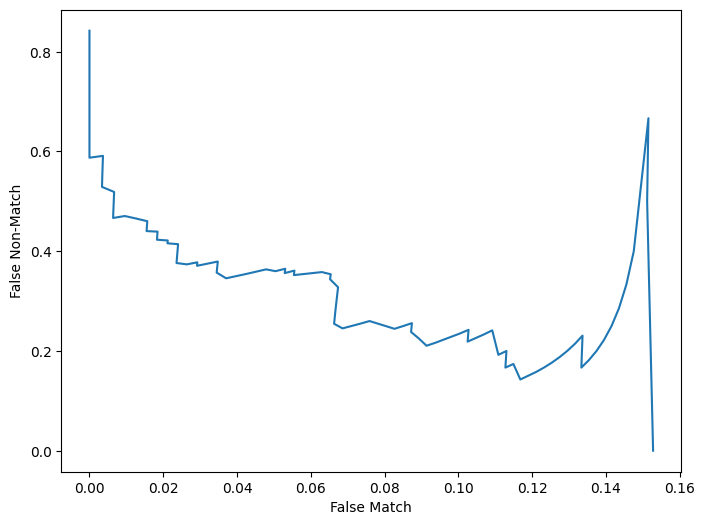

In [32]:
#%% Feature Extraction:
print('Starting Feature Extraction')
train_feature = train_enh.apply(extract, axis=1)
test_feature = test_enh.apply(extract, axis=1)

#%% Matching:
x_train = np.array(train_feature.values.tolist())
y_train = np.ravel([[x, x, x] for x in range(1, 109)])
x_test = np.array(test_feature.values.tolist())
y_test = np.ravel([[x, x, x, x] for x in range(1, 109)])

#%% Evaluation:
print('Starting Iris Matching')
val_d0, y_pred_d0 = match(x_train, y_train, x_test, y_test, reduction=False)
val_d, y_pred_d = match(x_train, y_train, x_test, y_test, reduction=True, n_comp=120)

#%%
print('Evaluation Results')
print(create_table(y_pred_d0, y_pred_d, y_test))

dimension_plot(x_train, x_test, y_train, y_test)

print(create_table2(val_d, y_pred_d))

fp_plot(val_d, y_pred_d)